# Introduction
In this notebook I am going to to take a look at the Boston AirBnB data: https://www.kaggle.com/airbnb/boston. My goal is to explore some basic trends in the types of listings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

complete_listings_df = pd.read_csv('Boston/Listings.csv')

There are many variables (columns in the pandas DataFrame) that have data from every single listing (rows in the pandas DataFrame).

In [3]:
no_nulls = complete_listings_df.columns[complete_listings_df.isnull().mean() == 0]
print('There are %d columns with no missing values.' % (no_nulls.shape[0]))
set(no_nulls)

There are 51 columns with no missing values.


{'accommodates',
 'amenities',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'bed_type',
 'calculated_host_listings_count',
 'calendar_last_scraped',
 'calendar_updated',
 'cancellation_policy',
 'country',
 'country_code',
 'description',
 'experiences_offered',
 'extra_people',
 'guests_included',
 'host_has_profile_pic',
 'host_id',
 'host_identity_verified',
 'host_is_superhost',
 'host_listings_count',
 'host_name',
 'host_picture_url',
 'host_since',
 'host_thumbnail_url',
 'host_total_listings_count',
 'host_url',
 'host_verifications',
 'id',
 'instant_bookable',
 'is_location_exact',
 'last_scraped',
 'latitude',
 'listing_url',
 'longitude',
 'maximum_nights',
 'minimum_nights',
 'name',
 'neighbourhood_cleansed',
 'number_of_reviews',
 'picture_url',
 'price',
 'require_guest_phone_verification',
 'require_guest_profile_picture',
 'requires_license',
 'room_type',
 'scrape_id',
 'smart_location',
 'state',
 'street'}

In [4]:
most_missing_cols = complete_listings_df.columns[complete_listings_df.isnull().mean()>0.5]

print('There are %d columns with more than half of their values missing.' % (most_missing_cols.shape[0]))
set(most_missing_cols)

There are 9 columns with more than half of their values missing.


{'has_availability',
 'jurisdiction_names',
 'license',
 'monthly_price',
 'neighbourhood_group_cleansed',
 'notes',
 'security_deposit',
 'square_feet',
 'weekly_price'}

In [6]:
# Convert the price data from strings to integers.
listings_df = complete_listings_df
listings_df['price'] = complete_listings_df['price'].apply(lambda p: int(p[1:-3].replace(",", "")))

## Type of housing
How much does the type of housing effect the price? Being able to rent the entire home/apt means that you can earn a higher price. A majority of listings offer this option.

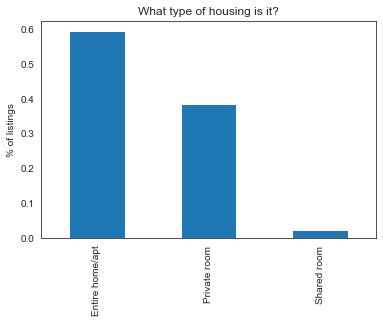

In [7]:
room_type_vals = listings_df['room_type'].value_counts()

(room_type_vals/listings_df.shape[0]).plot(kind="bar");
plt.title("What type of housing is it?");
plt.ylabel("% of listings");

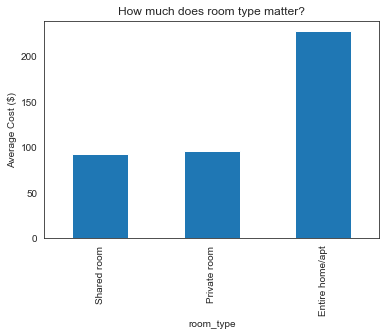

In [8]:
listings_df.groupby(['room_type']).mean()['price'].sort_values().plot(kind='bar');
plt.title("How much does room type matter?");
plt.ylabel("Average Cost ($)");

## Number of people listing can accommodate.
How much does the number of people who can share the room effect price? Very few listings allow more than 6 people.

Text(0, 0.5, '% of listings')

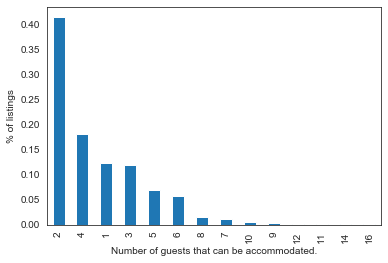

In [9]:
listings_vals = listings_df['accommodates'].value_counts()

(listings_vals/listings_df.shape[0]).plot(kind="bar")
plt.xlabel("Number of guests that can be accommodated.")
plt.ylabel("% of listings")

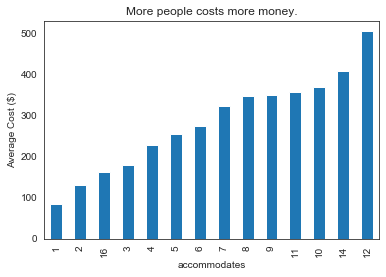

In [10]:
listings_df.groupby(['accommodates']).mean()['price'].sort_values().plot(kind='bar');
plt.title("More people costs more money.");
plt.ylabel("Average Cost ($)");

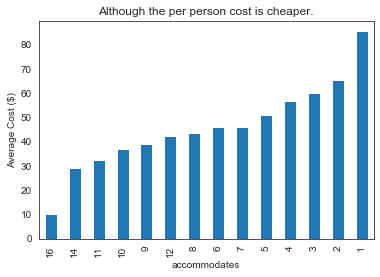

In [12]:
(listings_df.groupby(['accommodates']).mean()['price']/listings_df.groupby(['accommodates']).mean().index).sort_values().plot(kind='bar');
plt.title("Although the per person cost is cheaper.");
plt.ylabel("Average Cost ($)");

## Neighbourhods
Some neighbourhoods have more listings. Some neighbourhoods cost more money.

In [13]:
print('%f values missing from this column.' % (listings_df['neighbourhood'].isnull().mean()))

0.151464 values missing from this column.


Text(0, 0.5, 'Number of listings.')

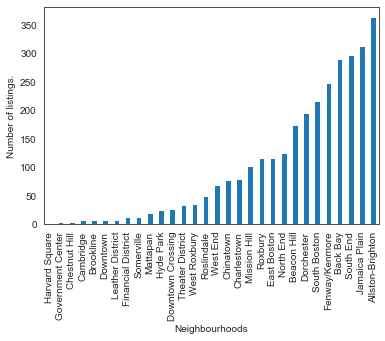

In [14]:
listings_df['neighbourhood'].dropna().value_counts().sort_values().plot(kind='bar')
plt.xlabel("Neighbourhoods")
plt.ylabel("Number of listings.")

Text(0, 0.5, 'Average price.')

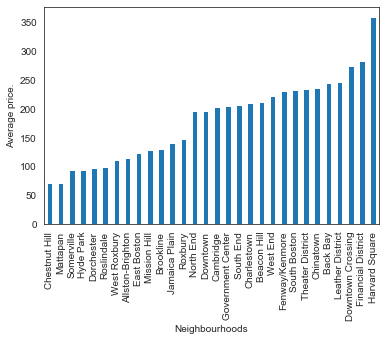

In [15]:
listings_df.groupby(['neighbourhood']).mean()['price'].sort_values().plot(kind='bar')
plt.xlabel("Neighbourhoods")
plt.ylabel("Average price.")